In [2]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  1962k      0  0:00:41  0:00:41 --:--:-- 2890k


In [3]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category,exist_ok=True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

training_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size, validation_split=0.8, subset="training", seed=1337, class_names=["neg", "pos"], label_mode="binary"
).take(100)
validation_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
testing_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = training_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [4]:
from tensorflow.keras import layers

max_length = 150
max_tokens = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = training_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = validation_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = testing_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [5]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 10000)       0         
                                                                 
 bidirectional (Bidirection  (None, 64)                2568448   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2568513 (9.80 MB)
Trainable params: 2568513 (9.80 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [6]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.x",
                                    save_best_only=True)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.x")
print(f"Training accc: {model.evaluate(int_train_ds)[1]:.3f}")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
100/100 [==============================] - 24s 157ms/step - loss: 0.6919 - accuracy: 0.5259 - val_loss: 0.6903 - val_accuracy: 0.5552
Epoch 2/10
100/100 [==============================] - 15s 150ms/step - loss: 0.6459 - accuracy: 0.6497 - val_loss: 0.5641 - val_accuracy: 0.7516
Epoch 3/10
100/100 [==============================] - 14s 145ms/step - loss: 0.4948 - accuracy: 0.7728 - val_loss: 0.4914 - val_accuracy: 0.7812
Epoch 4/10
100/100 [==============================] - 15s 153ms/step - loss: 0.3731 - accuracy: 0.8484 - val_loss: 0.4792 - val_accuracy: 0.7988
Epoch 5/10
100/100 [==============================] - 15s 149ms/step - loss: 0.2848 - accuracy: 0.8931 - val_loss: 0.4448 - val_accuracy: 0.8026
Epoch 6/10
100/100 [==============================] - 6s 62ms/step - loss: 0.2171 - accuracy: 0.9187 - val_loss: 0.5618 - val_accuracy: 0.7390
Epoch 7/10
100/100 [==============================] - 6s 61ms/step - loss: 0.1857 - accuracy: 0.9287 - val_loss: 0.5745 - val_accura

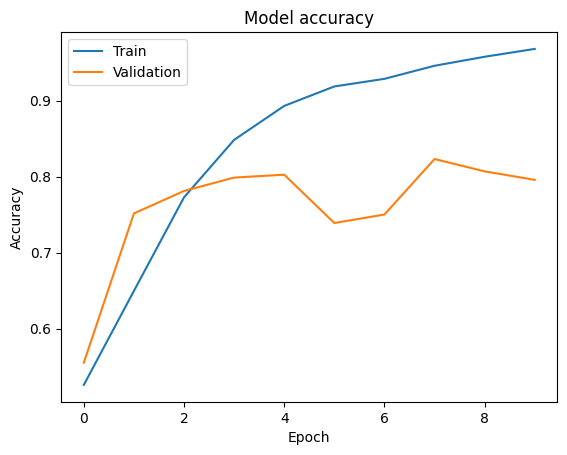

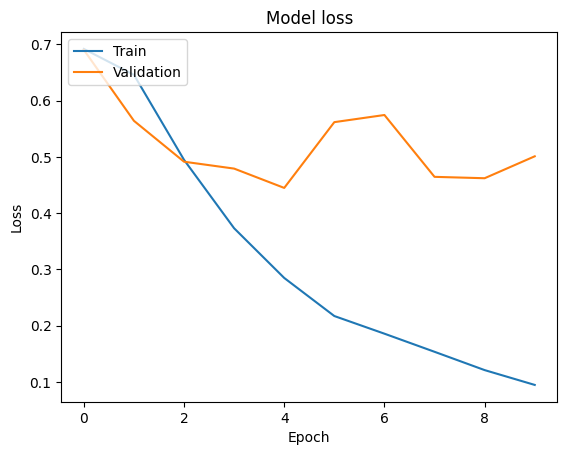

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [8]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.x",
                                    save_best_only=True)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.x")
print(f"Training accc: {model.evaluate(int_train_ds)[1]:.3f}")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         2560000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

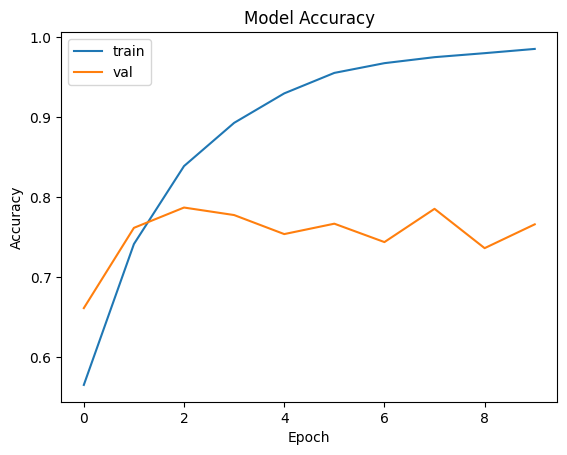

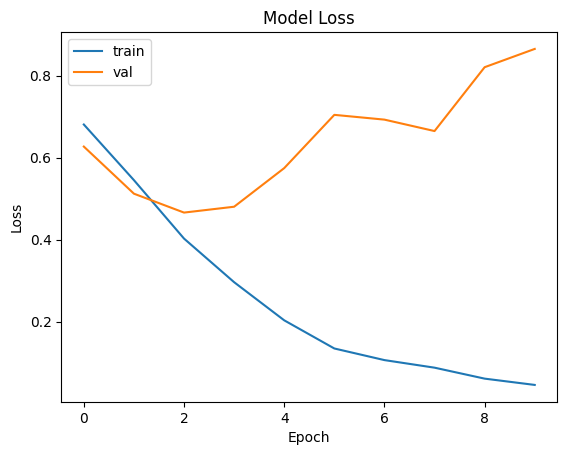

In [9]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

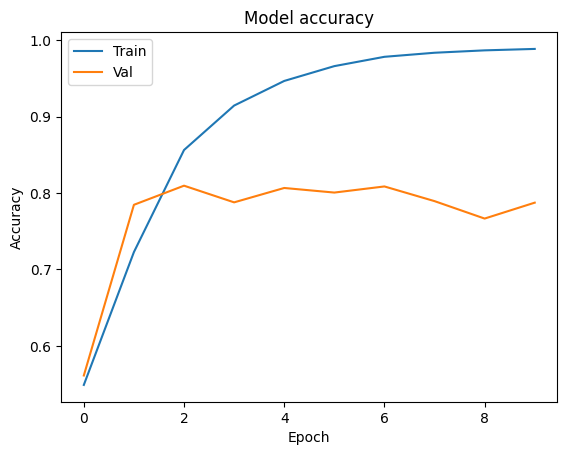

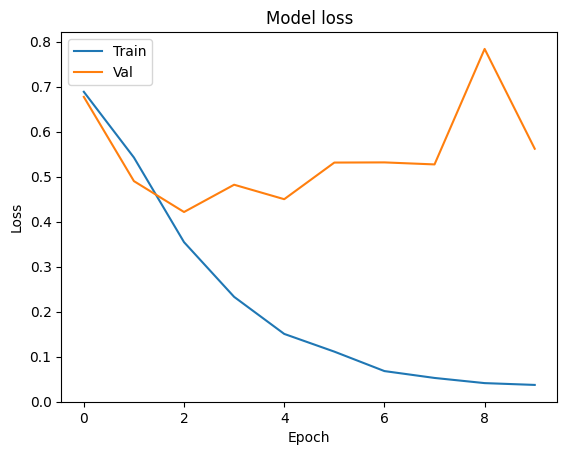

In [10]:
import matplotlib.pyplot as plt

# Define the model architecture
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

# Define the callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.x",
                                    save_best_only=True),
    keras.callbacks.History()
]

history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.x")
print(f"Training accc: {model.evaluate(int_train_ds)[1]:.3f}")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

# Plot the training and validation accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


Using Pretrained word Embedding

In [11]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

embedding_dim = 100
max_tokens = 10000
max_len = 150
num_samples = 100
validation_samples = 10000

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
word_index = {k: v for k, v in word_index.items() if v < max_tokens}

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.x",
                                    save_best_only=True)
]


history = model.fit(int_train_ds.take(num_samples).cache(),
          validation_data=int_val_ds.take(validation_samples).cache(),
          epochs=10, callbacks=callbacks)

model = keras.models.load_model("glove_embeddings_sequence_model.x")
_, test_acc = model.evaluate(int_test_ds.take(validation_samples))
print(f"Test acc: {test_acc:.3f}")




--2023-11-28 02:00:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-11-28 02:00:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-11-28 02:00:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

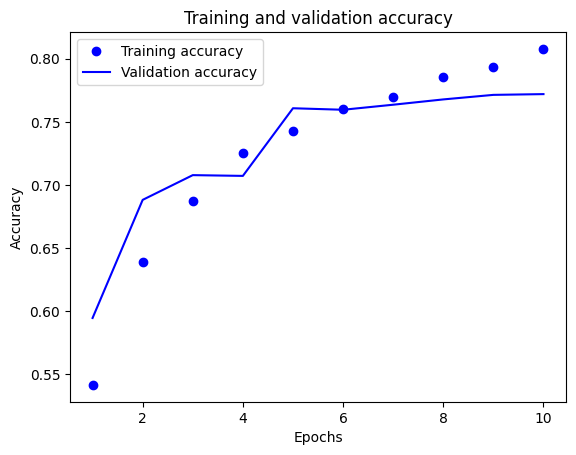

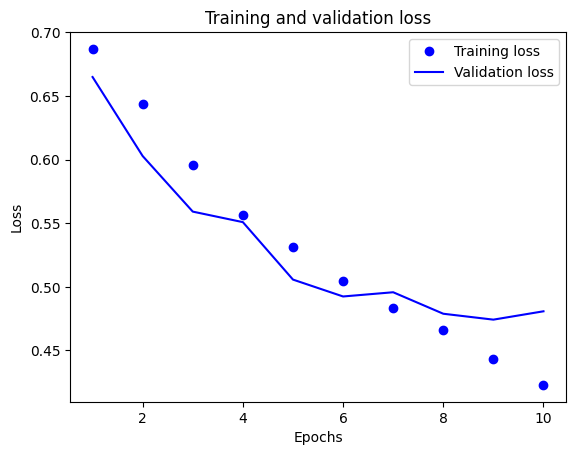

In [12]:
# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Using the different training samples for the embedding layer

Found 25000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.
Epoch 1/10
250/250 [==============================] - 39s 122ms/step - loss: 0.5777 - accuracy: 0.6837 - val_loss: 0.4342 - val_accuracy: 0.8090
Epoch 2/10
250/250 [==============================] - 24s 95ms/step - loss: 0.3636 - accuracy: 0.8494 - val_loss: 0.3997 - val_accuracy: 0.8170
Epoch 3/10
250/250 [==============================] - 6s 23ms/step - loss: 0.2644 - accuracy: 0.8996 - val_loss: 0.4355 - val_accuracy: 0.8190
Epoch 4/10
250/250 [==============================] - 5s 18ms/step - loss: 0.1936 - accuracy: 0.9305 - val_loss: 0.4917 - val_accuracy: 0.8225
Epoch 5/10
250/250 [==============================] - 5s 19ms/step - loss: 0.1413 - accuracy: 0.9489 - val_loss: 0.5713 - val_accuracy: 0.8165
Epoch 6/10
250/250 

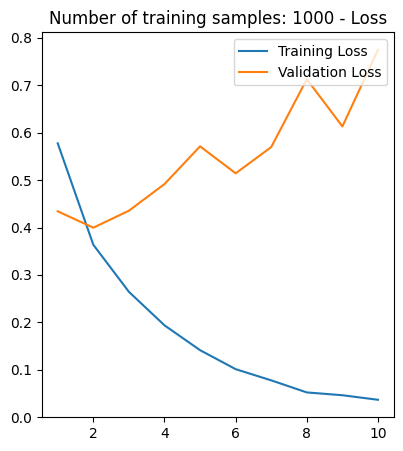

Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.
Epoch 1/10
250/250 [==============================] - 39s 129ms/step - loss: 0.5799 - accuracy: 0.6815 - val_loss: 0.4424 - val_accuracy: 0.8075
Epoch 2/10
250/250 [==============================] - 7s 29ms/step - loss: 0.3732 - accuracy: 0.8413 - val_loss: 0.4603 - val_accuracy: 0.8015
Epoch 3/10
250/250 [==============================] - 22s 87ms/step - loss: 0.2768 - accuracy: 0.8936 - val_loss: 0.3949 - val_accuracy: 0.8350
Epoch 4/10
250/250 [==============================] - 5s 19ms/step - loss: 0.2085 - accuracy: 0.9249 - val_loss: 0.5752 - val_accuracy: 0.7740
Epoch 5/10
250/250 [==============================] - 5s 19ms/step - loss: 0.1501 - accuracy: 0.9466 - val_loss: 0.4950 - val_accuracy: 0.8220
Epoch 6/10
250/250 [==============================] - 4s 18ms/step - loss: 0.1131 - accuracy: 0.9621 - val_loss: 0.5393 - val_accuracy

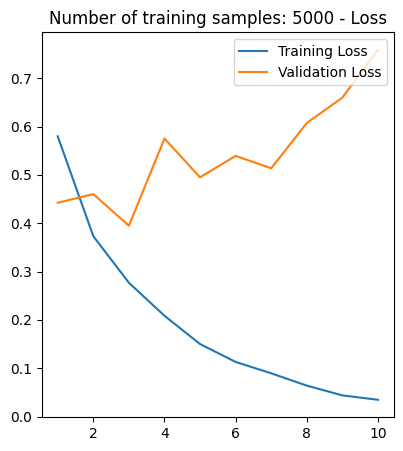

Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.
Epoch 1/10
250/250 [==============================] - 39s 128ms/step - loss: 0.5922 - accuracy: 0.6670 - val_loss: 0.4527 - val_accuracy: 0.7865
Epoch 2/10
250/250 [==============================] - 24s 95ms/step - loss: 0.3933 - accuracy: 0.8332 - val_loss: 0.4072 - val_accuracy: 0.8135
Epoch 3/10
250/250 [==============================] - 6s 22ms/step - loss: 0.2915 - accuracy: 0.8855 - val_loss: 0.4646 - val_accuracy: 0.8145
Epoch 4/10
250/250 [==============================] - 5s 18ms/step - loss: 0.2195 - accuracy: 0.9202 - val_loss: 0.4975 - val_accuracy: 0.8100
Epoch 5/10
250/250 [==============================] - 5s 18ms/step - loss: 0.1618 - accuracy: 0.9410 - val_loss: 0.5126 - val_accuracy: 0.8205
Epoch 6/10
250/250 [==============================] - 5s 18ms/step - loss: 0.1231 - accuracy: 0.9578 - val_loss: 0.5265 - val_accuracy

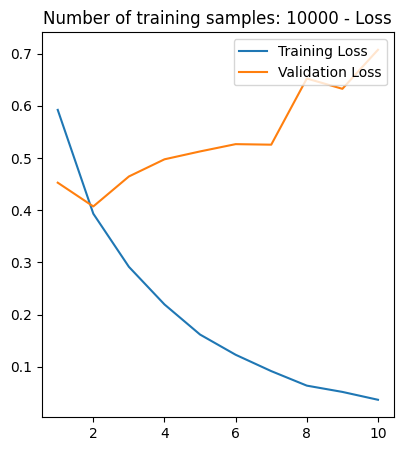

Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.
Epoch 1/10
250/250 [==============================] - 38s 126ms/step - loss: 0.6026 - accuracy: 0.6528 - val_loss: 0.4608 - val_accuracy: 0.7965
Epoch 2/10
250/250 [==============================] - 24s 95ms/step - loss: 0.3816 - accuracy: 0.8410 - val_loss: 0.4360 - val_accuracy: 0.8170
Epoch 3/10
250/250 [==============================] - 22s 87ms/step - loss: 0.2720 - accuracy: 0.8907 - val_loss: 0.4277 - val_accuracy: 0.8125
Epoch 4/10
250/250 [==============================] - 5s 20ms/step - loss: 0.1981 - accuracy: 0.9256 - val_loss: 0.5725 - val_accuracy: 0.7935
Epoch 5/10
250/250 [==============================] - 4s 18ms/step - loss: 0.1468 - accuracy: 0.9470 - val_loss: 0.4839 - val_accuracy: 0.8220
Epoch 6/10
250/250 [==============================] - 4s 18ms/step - loss: 0.1023 - accuracy: 0.9663 - val_loss: 0.4796 - val_accurac

In [ ]:
import os, pathlib, shutil, random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 32
max_length = 150
max_tokens = 10000
num_val_samples = 10000

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples_cat = int(num_val_samples/2)
    val_files = files[-num_val_samples_cat:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

test_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)

text_only_train_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=1337).map(lambda x, y: x)

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

text_vectorization.adapt(text_only_train_ds)

for num_train_samples in [1000, 5000, 10000, 15000, 20000, 25000]:
    train_ds = keras.preprocessing.text_dataset_from_directory(
        "aclImdb/train",
        batch_size=batch_size,
        validation_split=0.2,
        subset='training',
        seed=1337
    ).take(num_train_samples)

    val_ds = keras.preprocessing.text_dataset_from_directory(
        "aclImdb/train",
        batch_size=batch_size,
        validation_split=0.2,
        subset='validation',
        seed=1337
    ).take(num_val_samples)

    int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
    int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
    int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = layers.Embedding(
        input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint(f"embeddings_bidir_gru_with_masking_{num_train_samples}.x",
                                        save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

    model = keras.models.load_model(f"embeddings_bidir_gru_with_masking_{num_train_samples}.x")
    test_acc = model.evaluate(int_test_ds)[1]
    print(f"Number of training samples: {num_train_samples} - Test accuracy: {test_acc:.3f}")



    # Plot the training and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Number of training samples: {num_train_samples} - Loss')

    plt.show()

#Plot the training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(acc) + 1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title(f'Number of training samples: {num_train_samples} - Accuracy')
plt.show()
